In [ ]:
! pip install qdrant_client

In [1]:
from qdrant_client import QdrantClient

client = QdrantClient(url="http://localhost:6333")

/home/gwm-279/Documents/DTC_AI/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from qdrant_client.models import Distance
dir(Distance)

['COSINE',
 'DOT',
 'EUCLID',
 'MANHATTAN',
 '__class__',
 '__doc__',
 '__members__',
 '__module__']

In [3]:
from qdrant_client.models import Distance, VectorParams

client.create_collection(
    collection_name="test_collection",
    vectors_config=VectorParams(size=4, distance=Distance.DOT),
)

True

In [4]:
from qdrant_client.models import PointStruct

operation_info = client.upsert(
    collection_name="test_collection",
    wait=True,
    points=[
        PointStruct(id=1, vector=[0.05, 0.61, 0.76, 0.74], payload={"city": "Berlin"}),
        PointStruct(id=2, vector=[0.19, 0.81, 0.75, 0.11], payload={"city": "London"}),
        PointStruct(id=3, vector=[0.36, 0.55, 0.47, 0.94], payload={"city": "Moscow"}),
        PointStruct(id=4, vector=[0.18, 0.01, 0.85, 0.80], payload={"city": "New York"}),
        PointStruct(id=5, vector=[0.24, 0.18, 0.22, 0.44], payload={"city": "Beijing"}),
        PointStruct(id=6, vector=[0.35, 0.08, 0.11, 0.44], payload={"city": "Mumbai"}),
    ],
)

print(operation_info)

operation_id=1 status=<UpdateStatus.COMPLETED: 'completed'>


In [5]:
search_result = client.query_points(
    collection_name="test_collection",
    query=[0.2, 0.1, 0.9, 0.7],
    with_payload=False,
    limit=3
).points

print(search_result)

[ScoredPoint(id=4, version=1, score=1.362, payload=None, vector=None, shard_key=None, order_value=None), ScoredPoint(id=1, version=1, score=1.273, payload=None, vector=None, shard_key=None, order_value=None), ScoredPoint(id=3, version=1, score=1.208, payload=None, vector=None, shard_key=None, order_value=None)]


In [6]:
from qdrant_client.models import Filter, FieldCondition, MatchValue

search_result = client.query_points(
    collection_name="test_collection",
    query=[0.2, 0.1, 0.9, 0.7],
    query_filter=Filter(
        must=[FieldCondition(key="city", match=MatchValue(value="London"))]
    ),
    with_payload=True,
    limit=3,
).points

print(search_result)

[ScoredPoint(id=2, version=1, score=0.871, payload={'city': 'London'}, vector=None, shard_key=None, order_value=None)]


In [38]:
# Using the client data 

import json 
with open('documents.json', 'r') as f:
    documents = json.load(f)

documents_flatten = []

course_list = []

for doc in documents:
    course_list.append(doc.get('course'))
    for q_a in doc.get('documents'):
        q_a['course'] = doc.get('course')
        documents_flatten.append(q_a)

print(course_list)
len(documents_flatten)


['data-engineering-zoomcamp', 'machine-learning-zoomcamp', 'mlops-zoomcamp']


948

In [ ]:
! pip install fastembed

In [8]:
from fastembed import TextEmbedding

TextEmbedding.list_supported_models() 
EMBEDDING_DIMENSIONALITY = 384

for model in TextEmbedding.list_supported_models():
    if model["dim"] == EMBEDDING_DIMENSIONALITY:
        print(json.dumps(model, indent=2))

{
  "model": "BAAI/bge-small-en",
  "sources": {
    "hf": "Qdrant/bge-small-en",
    "url": "https://storage.googleapis.com/qdrant-fastembed/BAAI-bge-small-en.tar.gz",
    "_deprecated_tar_struct": true
  },
  "model_file": "model_optimized.onnx",
  "description": "Text embeddings, Unimodal (text), English, 512 input tokens truncation, Prefixes for queries/documents: necessary, 2023 year.",
  "license": "mit",
  "size_in_GB": 0.13,
  "additional_files": [],
  "dim": 384,
  "tasks": {}
}
{
  "model": "BAAI/bge-small-en-v1.5",
  "sources": {
    "hf": "qdrant/bge-small-en-v1.5-onnx-q",
    "url": null,
    "_deprecated_tar_struct": false
  },
  "model_file": "model_optimized.onnx",
  "description": "Text embeddings, Unimodal (text), English, 512 input tokens truncation, Prefixes for queries/documents: not so necessary, 2023 year.",
  "license": "mit",
  "size_in_GB": 0.067,
  "additional_files": [],
  "dim": 384,
  "tasks": {}
}
{
  "model": "snowflake/snowflake-arctic-embed-xs",
  "sou

In [11]:
EMBEDDING_MODEL = "BAAI/bge-small-en" 

In [9]:
from qdrant_client.models import Distance, VectorParams

COLLECTION_NAME = "course_faq"

client.create_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=VectorParams(size=EMBEDDING_DIMENSIONALITY, distance=Distance.COSINE),
)

True

In [18]:
documents_flatten[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp'}

In [12]:

from qdrant_client import models
points = []
id = 0

for doc in documents_flatten:
        point = models.PointStruct(
            id=id,
            vector=models.Document(text=doc['text'], model=EMBEDDING_MODEL), #embed text locally with "jinaai/jina-embeddings-v2-small-en" from FastEmbed
            payload={
                "text": doc['text'],
                "section": doc['section'],
                "course": doc['course']
            } 
        )
        points.append(point)
        id += 1

In [13]:
points[0]

PointStruct(id=0, vector=Document(text="The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.", model='BAAI/bge-small-en', options=None), payload={'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Clu

In [14]:
from qdrant_client import QdrantClient
client.upsert(
    collection_name=COLLECTION_NAME,
    points=points
)

Fetching 5 files: 100%|██████████| 5/5 [00:20<00:00,  4.16s/it]


UpdateResult(operation_id=1, status=<UpdateStatus.COMPLETED: 'completed'>)

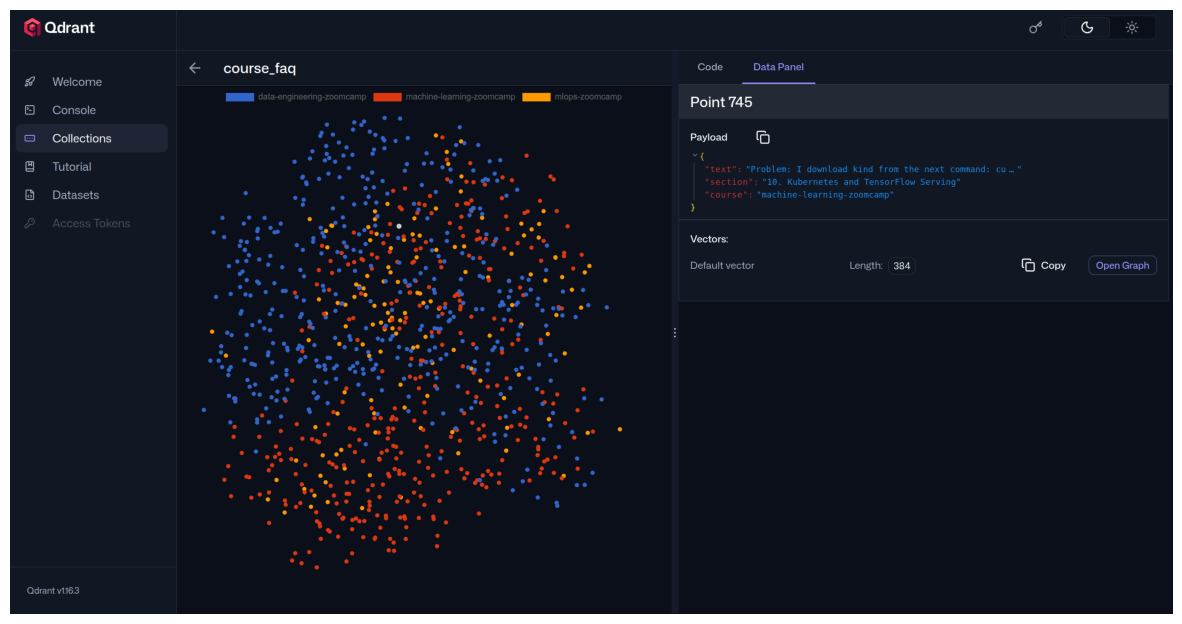

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15, 10))
img = mpimg.imread('Screenshot from 2026-01-29 09-28-55.png')

plt.imshow(img)
plt.axis('off') 
plt.show()

In [37]:
query = 'Which Os are supported?'

results = client.query_points(
    collection_name=COLLECTION_NAME,
    query=models.Document( 
        text=query,
        model=EMBEDDING_MODEL 
    ),
    limit=3,
    with_payload=True 
)

if results.points:
    extracted_texts = [p.payload for p in results.points]
    scores = [p.score for p in results.points]
    for text, score in zip(extracted_texts, scores):
        print("-" * 30)
        print(f'Score: {score}')
        print(f'Course: {text["course"]}')
        print(f'Matched Text: {text["text"]}')

------------------------------
Score: 0.8734072
Course: data-engineering-zoomcamp
Matched Text: Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully
------------------------------
Score: 0.8726361
Course: data-engineering-zoomcamp
Matched Text: probably some installation error, check out sy
------------------------------
Score: 0.84542966
Course: machine-learning-zoomcamp
Matched Text: That’s normal. We all have different environments: our computers have different versions of OS and different versions of libraries — even different versions of Python.
If it’s the case, just select the option that’s closest to your answer


In [ ]:
client.create_payload_index(
    collection_name=COLLECTION_NAME,
    field_name="course",
    field_schema="keyword" 
) 

In [39]:
course_list

['data-engineering-zoomcamp', 'machine-learning-zoomcamp', 'mlops-zoomcamp']

In [40]:

results = client.query_points(
        collection_name=COLLECTION_NAME,
        query=models.Document( 
            text=query,
            model=EMBEDDING_MODEL
        ),
        query_filter=models.Filter( 
            must=[
                models.FieldCondition(
                    key="course",
                    match=models.MatchValue(value=course_list[0])
                )
            ]
        ),
        limit=3, 
        with_payload=True
    )

if results.points:
    extracted_texts = [p.payload for p in results.points]
    scores = [p.score for p in results.points]
    for text, score in zip(extracted_texts, scores):
        print("-" * 30)
        print(f'Score: {score}')
        print(f'Course: {text["course"]}')
        print(f'Matched Text: {text["text"]}')

------------------------------
Score: 0.8734072
Course: data-engineering-zoomcamp
Matched Text: Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully
------------------------------
Score: 0.8726361
Course: data-engineering-zoomcamp
Matched Text: probably some installation error, check out sy
------------------------------
Score: 0.83377254
Course: data-engineering-zoomcamp
Matched Text: It's up to you which platform and environment you use for the course.
Github codespaces or GCP VM are just possible options, but you can do the entire course from your laptop.


In [41]:
def search_result(query, course_filter=None, limit=3):
    if course_filter:
        query_filter = models.Filter( 
            must=[
                models.FieldCondition(
                    key="course",
                    match=models.MatchValue(value=course_filter)
                )
            ]
        )
    else:
        query_filter = None

    results = client.query_points(
        collection_name=COLLECTION_NAME,
        query=models.Document( 
            text=query,
            model=EMBEDDING_MODEL
        ),
        query_filter=query_filter,
        limit=limit, 
        with_payload=True
    )

    formatted_results = []
    if results.points:
        for p in results.points:
            formatted_results.append({
                "score": p.score,
                "course": p.payload["course"],
                "text": p.payload["text"]
            })
    return formatted_results

In [43]:
search_result("When is homework deadline?", course_filter=course_list[1], limit=2)

[{'score': 0.8797134,
  'course': 'machine-learning-zoomcamp',
  'text': 'No, it’s not possible. The form is closed after the due date. But don’t worry, homework is not mandatory for finishing the course.'},
 {'score': 0.87217677,
  'course': 'machine-learning-zoomcamp',
  'text': "Depends on whether the form will still be open. If you're lucky and it's open, you can submit your homework and it will be evaluated. if closed - it's too late.\n(Added by Rileen Sinha, based on answer by Alexey on Slack)"}]

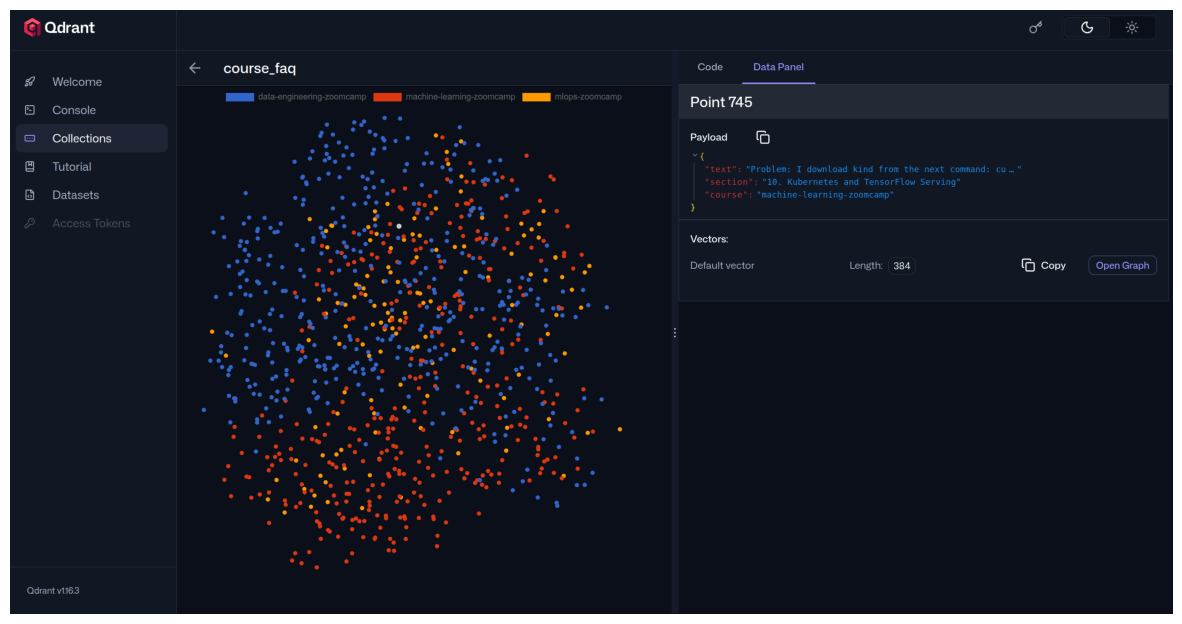